In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os

def load_binary_spectrograms(hdf5_file):
    """
    Loads and normalizes grayscale spectrograms from an HDF5 file for binary classification.
    Only the classes 'amerob' and 'rewbla' are used.

    Parameters:
        hdf5_file (str): Path to the HDF5 file containing spectrogram datasets.

    Returns:
        X_train (np.ndarray): Training spectrograms.
        X_val (np.ndarray): Validation spectrograms.
        X_test (np.ndarray): Test spectrograms.
        y_train (np.ndarray): Binary labels for training set.
        y_val (np.ndarray): Binary labels for validation set.
        y_test (np.ndarray): Binary labels for test set.
    """
    labels = ['amerob', 'rewbla']
    data = []
    labels_list = []

    with h5py.File(hdf5_file, 'r') as data_file:
        for label in labels:
            spectrogram = data_file[label][...].astype(np.float32) / 255.0
            spectrogram = np.transpose(spectrogram, (2, 0, 1))
            data.append(spectrogram)
            label_id = labels.index(label)
            labels_list.append(np.full(spectrogram.shape[0], label_id, dtype=np.uint8))

    X = np.concatenate(data, axis=0)[..., np.newaxis]
    y = np.concatenate(labels_list, axis=0)
    X, y = shuffle(X, y, random_state=123)

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=123)

    return X_train, X_val, X_test, y_train, y_val, y_test

def build_binary_cnn(input_shape, learning_rate=1e-4, dropout_rate=0.5, l2_reg=0.02):
    """
    Builds and compiles a CNN model for binary classification with dropout and L2 regularization.

    Parameters:
        input_shape (tuple): Shape of input spectrograms, e.g. (128, 517, 1).
        learning_rate (float): Learning rate for the Adam optimizer.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization strength for Conv and Dense layers.

    Returns:
        model (tf.keras.Model): Compiled CNN model ready for training.
    """
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(512, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

def train_model_with_callbacks(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32):
    """
    Trains the CNN model using early stopping, model checkpointing, and learning rate scheduling.

    Parameters:
        model (tf.keras.Model): The compiled model to train.
        X_train (np.ndarray): Training spectrogram data.
        y_train (np.ndarray): Labels for training data.
        X_val (np.ndarray): Validation spectrogram data.
        y_val (np.ndarray): Labels for validation data.
        epochs (int): Maximum number of epochs to train.
        batch_size (int): Number of samples per training batch.

    Returns:
        history (tf.keras.callbacks.History): Training history object containing loss/accuracy logs.
    """
    checkpoint_path = r"D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/models/cnn_amerob_rewbla_model.keras"

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    return history

def plot_training_performance(history):
    """
    Plots training and validation accuracy and loss over epochs.

    Parameters:
        history (tf.keras.callbacks.History): Training history object with accuracy/loss values.

    Returns:
        None: Displays matplotlib plots directly.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(hdf5_path, model_name='cnn_binary', batch_size=32, epochs=200,
                                    learning_rate=1e-4, dropout_rate=0.5, l2_reg=0.02):
    """
    Loads data, builds the CNN, trains it, evaluates performance, and saves the final model.

    Parameters:
        hdf5_path (str): Path to the HDF5 file containing the spectrogram data.
        model_name (str): Prefix name for saving the trained model.
        batch_size (int): Batch size used during training.
        epochs (int): Maximum number of training epochs.
        learning_rate (float): Learning rate for the Adam optimizer.
        dropout_rate (float): Dropout rate for regularization.
        l2_reg (float): L2 regularization strength.

    Returns:
        None: Prints results and saves the model to disk.
    """
    X_train, X_val, X_test, y_train, y_val, y_test = load_binary_spectrograms(hdf5_path)

    model = build_binary_cnn(input_shape=(128, 517, 1),
                             learning_rate=learning_rate,
                             dropout_rate=dropout_rate,
                             l2_reg=l2_reg)

    model.summary()

    history = train_model_with_callbacks(model, X_train, y_train, X_val, y_val,
                                         epochs=epochs, batch_size=batch_size)

    plot_training_performance(history)

    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f} | AUC: {test_auc:.4f}")

    save_path = rf"D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/models/{model_name}.keras"
    model.save(save_path)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 517, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 517, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 127, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    61,932,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,025,729 (236.61 MB)

 Trainable params: 62,025,729 (236.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5657 - auc: 0.5141 - loss: 12.1962 - val_accuracy: 0.4861 - val_auc: 0.5579 - val_loss: 11.2344 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4932 - auc: 0.4024 - loss: 11.1250 - val_accuracy: 0.4861 - val_auc: 0.5552 - val_loss: 10.2367 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4739 - auc: 0.4670 - loss: 10.0556 - val_accuracy: 0.6250 - val_auc: 0.5000 - val_loss: 9.2693 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5648 - auc: 0.5508 - loss: 9.0865 - val_accuracy: 0.5139 - val_auc: 0.5000 - val_loss: 8.3620 - learning_rate: 1.0000e-04
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5245 - auc: 0.5445 - loss: 8.1931 - val_accuracy: 0.5139 - val_auc: 0.5000 - val_loss: 7.5303 - learning_rate: 1.0000e-04
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5386 - auc: 0

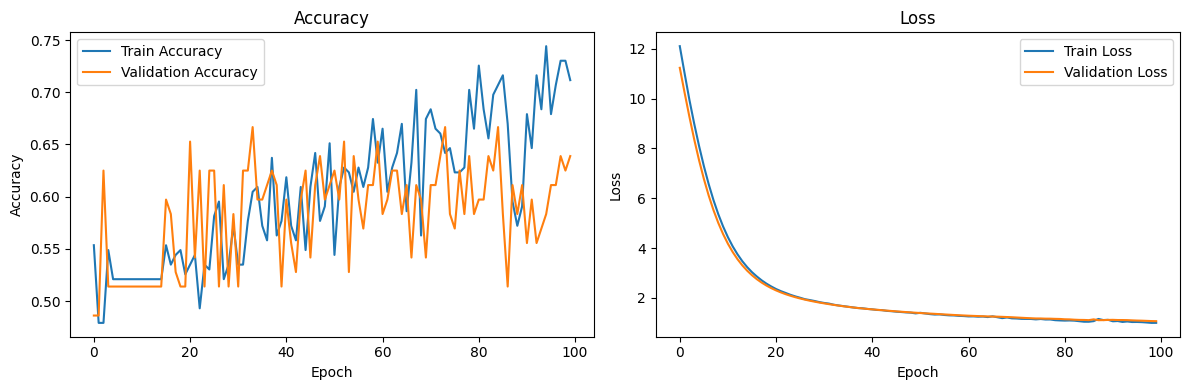


Test Accuracy: 0.6806 | AUC: 0.7384


In [7]:
train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='first_run_binary_cnn', 
    batch_size=64,
    epochs=100,
    learning_rate=1e-4,
    dropout_rate=0.4,
    l2_reg=0.01
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 517, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 517, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 127, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    61,932,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,025,729 (236.61 MB)

 Trainable params: 62,025,729 (236.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5430 - auc: 0.5621 - loss: 11.8980 - val_accuracy: 0.5139 - val_auc: 0.5185 - val_loss: 10.8778 - learning_rate: 1.0000e-04
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5230 - auc: 0.5202 - loss: 10.6039 - val_accuracy: 0.6111 - val_auc: 0.7143 - val_loss: 9.6157 - learning_rate: 1.0000e-04
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5371 - auc: 0.6509 - loss: 9.3284 - val_accuracy: 0.5417 - val_auc: 0.7108 - val_loss: 8.4653 - learning_rate: 1.0000e-04
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5187 - auc: 0.5215 - loss: 8.2259 - val_accuracy: 0.5000 - val_auc: 0.6919 - val_loss: 7.4641 - learning_rate: 1.0000e-04
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5069 - auc: 0.5405 - loss: 7.2837 - val_accuracy: 0.5833 - val_auc: 0.6386 - val_loss: 6.6196 - learning_rate: 1.0000e-04
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5261 - auc: 0.5

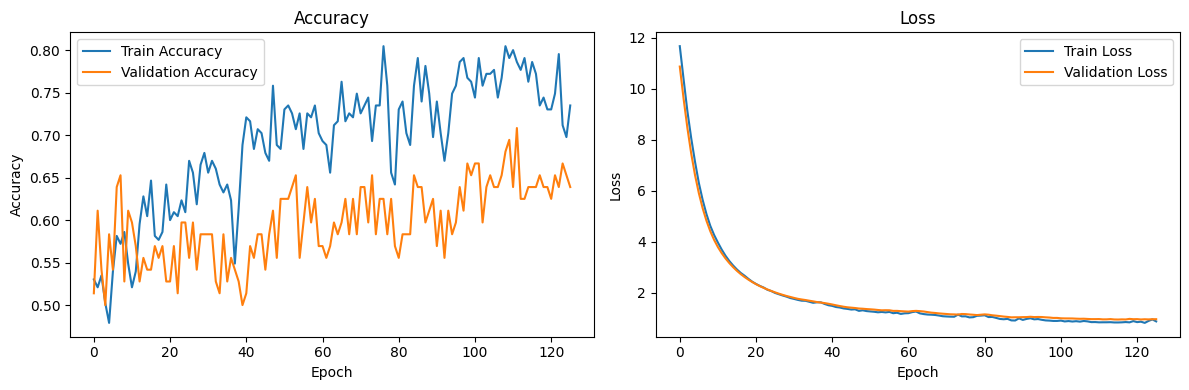


Test Accuracy: 0.6389 | AUC: 0.7179


In [8]:

train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='second_run_binary_cnn', 
    batch_size=32,
    epochs=200,
    learning_rate=1e-4,
    dropout_rate=0.5,
    l2_reg=0.01
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 517, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 517, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 258, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 258, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 129, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 30, 127, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 15, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 120960)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    61,932,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,025,729 (236.61 MB)

 Trainable params: 62,025,729 (236.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 830ms/step - accuracy: 0.5034 - auc: 0.4951 - loss: 11.4090 - val_accuracy: 0.5139 - val_auc: 0.4927 - val_loss: 8.7943 - learning_rate: 1.0000e-04
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 807ms/step - accuracy: 0.5130 - auc: 0.5412 - loss: 8.0949 - val_accuracy: 0.5139 - val_auc: 0.5560 - val_loss: 6.1831 - learning_rate: 1.0000e-04
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 781ms/step - accuracy: 0.4972 - auc: 0.5276 - loss: 5.7251 - val_accuracy: 0.5139 - val_auc: 0.5656 - val_loss: 4.5020 - learning_rate: 1.0000e-04
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 757ms/step - accuracy: 0.5561 - auc: 0.6424 - loss: 4.2016 - val_accuracy: 0.5000 - val_auc: 0.7015 - val_loss: 3.4804 - learning_rate: 1.0000e-04
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 766ms/step - accuracy: 0.5107 - auc: 0.5592 - loss: 3.3133 - val_accuracy: 0.6111 - val_auc: 0.6737 - val_loss: 2.8657 - learning_rate: 1.0000e-04
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 788ms/

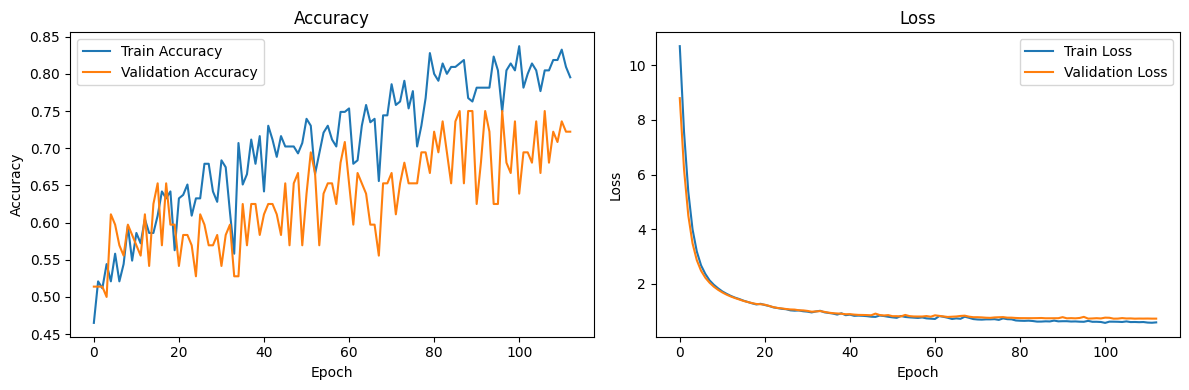


Test Accuracy: 0.6528 | AUC: 0.7457


In [9]:

train_and_evaluate_model(
    hdf5_path="D:/University_Course_Work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/bird_spectrograms.hdf5",
    model_name='second_run_binary_cnn', 
    batch_size=16,
    epochs=200,
    learning_rate=1e-4,
    dropout_rate=0.3,
    l2_reg=0.01
)

Testing the model witht he given audio

In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display

def predict_and_visualize_binary_species(model_path):
    """
    Loads a trained binary classification model and predicts species ('amerob' vs 'rewbla')
    from spectrograms stored in a predefined HDF5 file. It also visualizes each spectrogram
    and prints the predicted species along with confidence scores.

    Parameters:
        model_path (str): File path to the trained Keras binary classification model (.keras)
    """
    hdf5_path = "D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/Data/test_bird_spectrograms.hdf5"
    species_labels = ['amerob', 'rewbla']
    target_shape = (128, 517)

    model = tf.keras.models.load_model(model_path)

    with h5py.File(hdf5_path, 'r') as h5f:
        spectrogram_datasets = list(h5f.keys())
        spectrogram_data = []

        for dataset_name in spectrogram_datasets:
            spectrogram = h5f[dataset_name][...]
            if spectrogram.shape != target_shape:
                padding_width = target_shape[1] - spectrogram.shape[1]
                if padding_width > 0:
                    spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_width)), mode='constant')
                spectrogram = spectrogram[:, :target_shape[1]]
            spectrogram_data.append(spectrogram)

        spectrogram_data = np.array(spectrogram_data)[..., np.newaxis] / 255.0

    predictions = model.predict(spectrogram_data)

    for idx, dataset_name in enumerate(spectrogram_datasets):
        spectrogram = spectrogram_data[idx, ..., 0]

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', sr=22050, cmap='gray')
        predicted_prob = predictions[idx][0]
        predicted_label = 1 if predicted_prob >= 0.5 else 0
        plt.title(f"Prediction: {species_labels[predicted_label]}")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

        print(f"Predicted label for {dataset_name}: {species_labels[predicted_label]}")
        print(f"Prediction confidence for both species:")
        print(f"amerob: {1 - predicted_prob}")
        print(f"rewbla: {predicted_prob}")
        print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


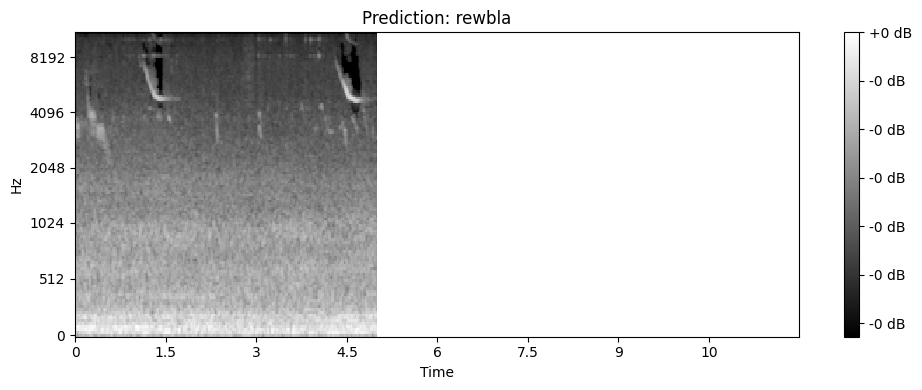

Predicted label for audio_1: rewbla
Prediction confidence for both species:
amerob: 0.4867900609970093
rewbla: 0.5132099390029907
--------------------------------------------------


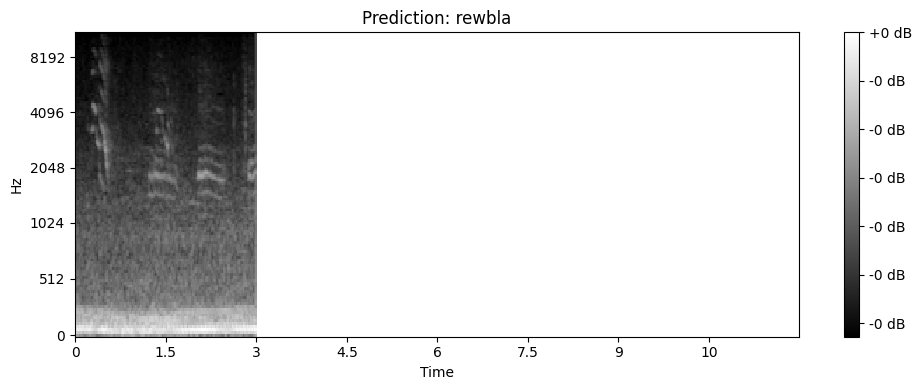

Predicted label for audio_2: rewbla
Prediction confidence for both species:
amerob: 0.44602668285369873
rewbla: 0.5539733171463013
--------------------------------------------------


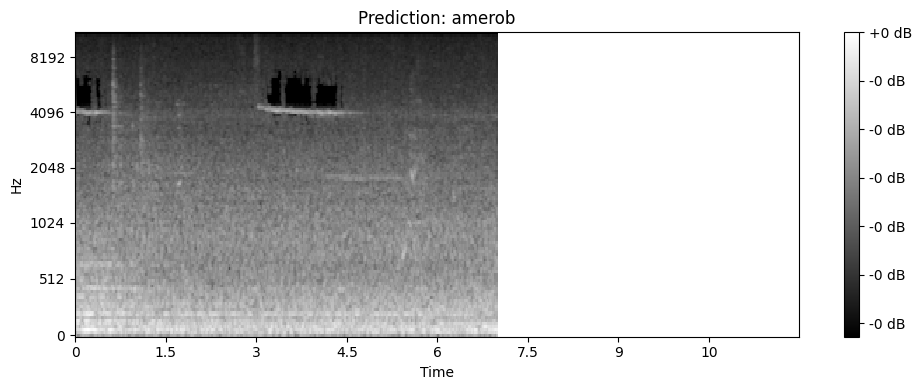

Predicted label for audio_3: amerob
Prediction confidence for both species:
amerob: 0.5207572281360626
rewbla: 0.4792427718639374
--------------------------------------------------


In [4]:
predict_and_visualize_binary_species("D:/University_Course_work/StatsML-2/Deeplearning/Practical_Home_Work/species_learning_with_deep_learning/models/first_run_binary_cnn.keras")
